<a href="https://colab.research.google.com/github/dmejiaho/TAM-2025-2/blob/main/Soluci%C3%B3n_de_2_DL_Keras_API_funcional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cuaderno original

## Creación de arquitecturas de aprendizaje profundo mediante API funcional de Keras.

- Se presentan los consideraciones básicas respecto a la [API funcional de Keras](https://keras.io/guides/functional_api/) para la implementación de modelos de redes profundas con TensorFlow.



In [ ]:
import tensorflow as tf #importar tensorflow
print(tf.__version__)

- Se utilizará la base de datos Fashion Mnist nuevamente, normalizando las imágenes de 0 a 1.

In [ ]:
train, test = tf.keras.datasets.fashion_mnist.load_data()
images, labels = train

- Se presenta un ejemplo de la base de datos

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images[5000,:,:],cmap= 'binary')
plt.show()

In [ ]:
import numpy as np
print(np.unique(labels)) #etiquetas
print(images.shape) #tamaño de las imágenes

In [ ]:
Xtrain, ytrain = train
Xtrain = Xtrain/255 # tipo flotante, normalizados de 0 a 1
Xtest, ytest = test
Xtest = Xtest/255 # tipo flotante, normalizados de 0 a 1

- En el cuaderno introductorio a redes neuronales con tensorflow se planteó la construcción de modelos mediante secuencia de capas:

In [ ]:
#definir arquitectura secuencial
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2])),
    tf.keras.layers.Dense(200,activation="relu", name='red1'),
    tf.keras.layers.Dense(50, activation="tanh",name='hred2'),
    tf.keras.layers.Dense(10,activation='softmax',name='output')
])

model.summary() # resumen del modelo
tf.keras.utils.plot_model(model) #diagrama del modelo

- Aunque la implementacióm mediante secuencia es intuitiva, no permite realizar conexiones flexibles entre capas.

- En ese sentido, Keras permite crear capas bajo el principio de funciones y argumentos, como se muestra a continuación.

**Nota**: a diferencia de la estructura secuencial, en la API funcional se debe indicar la capa o capas de entrada y la capa o capas de salida para crear el grafo computacional de forma apropiada.

In [ ]:
#arquitectura funcional
#capa de entrada
input_l = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2]), name='entrada')
#capa de aplanamiento de las imágenes
flatten = tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2]))(input_l)#argumento de entrada
#capas densas
h1 = tf.keras.layers.Dense(200,activation='tanh',name='h1')(flatten)#argumento de entrada
h2 = tf.keras.layers.Dense(50,activation='tanh',name='h2')(h1)
#capa de salida
output = tf.keras.layers.Dense(10,activation="softmax",name='output')(h2)
#crear modelo según conexiones tipo funcionales
model_fun = tf.keras.Model(inputs=input_l,outputs=output)

#resumen y gráfica del modelo
model_fun.summary()
tf.keras.utils.plot_model(model_fun)


## La API funcional permite realizar conexiones más flexibles

- En el siguiente ejemplo se crea un modelo con una entrada y dos salidas con interconexiones flexibles:

In [ ]:
#arquitectura funcional 2
tf.keras.backend.clear_session()
input_l = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2]), name='entrada')
flatten = tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2]))(input_l)

h1 = tf.keras.layers.Dense(200,activation='tanh',name='h1')(flatten)
h2 = tf.keras.layers.Dense(50,activation='tanh',name='h2')(h1)
#capa que concatena caracterísitacas extraídas en h2 con imágenes de entrada
concat = tf.keras.layers.concatenate([h2,flatten])
#se crean dos salidas:
output_A = tf.keras.layers.Dense(10,activation="softmax",name='outputA')(concat)#desde concatenación
output_B = tf.keras.layers.Dense(10,activation="softmax",name='outputB')(h2)#desde h2
#las entradas y salidas se ingresan como listas
model_fun = tf.keras.Model(inputs=input_l,outputs=[output_A, output_B])
#model_fun.summary()
tf.keras.utils.plot_model(model_fun)

**Nota**: si se cuenta con varias salidas se puede definir un mismo costo para cada salida, o una lista con los costos requeridos. Además, en la lista `loss_weights` se puede especificar el valor del peso asociado al costo de cada salida en el intervalo [0,1].

In [ ]:
model_fun.compile(loss="sparse_categorical_crossentropy", #custom_loss(),#custom_loss(),#"sparse_categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy","accuracy"]) #f1, precision, recall, crossentropy


- El entrenamiento se realiza de igual forma al utilizado con el modelo secuencial.

- Como se fijaron dos salidas, se debe ingresar una lista para los argumentos ytrain.

In [ ]:
history = model_fun.fit(Xtrain, [ytrain,ytrain] , epochs=10,batch_size=64, # 32, 64, 128, 256
                    validation_split=0.3) # se fija el conjunto de validación como el 20% del de train

- Se presentan las curvas de desempeño:

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
plt.show()

- Como el modelo generado presenta dos salidas, el rendimiento se discrimina por cada salida y el acumulado.

- A la hora de predecir la salida para una nueva muestra, se debe tener en cuenta la cantidad de salidas fijadas.

In [ ]:
yestA,yestB = model_fun.predict(Xtest)
print(yestA.shape,yestB.shape)#salidas tipo 1 -K probabilidad de membresia a cada clase

In [ ]:
print(yestA[0].argmax(),ytest[0])#para estimar la etiqueta ordinal se encuentra el max por columnas

In [ ]:
scoreA = model_fun.evaluate(Xtest,[ytest,ytest])#evaluacion
print(scoreA)

## Grafiquemos los pesos respecto a las dimensiones de la imagen original

In [ ]:
#se busca identificar las entradas más relevantes para la red
plt.imshow(abs(model.layers[1].get_weights()[0]).sum(axis=1).reshape(28,28))
plt.colorbar()
plt.show()

In [ ]:
model.layers[1].get_weights()[1].shape # accediendo a los bias

## Salidas parciales de la red

- La estrategia funcional nos permite acceder a partes intermedias de la red para encontrar mapas de características y verificar el aprendizaje de la representación.

In [ ]:
#crear nuevo modelo con salida parcial
model_B = tf.keras.Model(inputs=model_fun.inputs,outputs=model_fun.get_layer('h2').output) #se accede a capas por nombre
tf.keras.utils.plot_model(model_B) # modelo ya esta ajustado!


In [ ]:
z = model_B.predict(Xtest) # salida en h2
z.shape

### Dado que se fijaron 50 unidades, se pueden utilizar técnicas de reducción de dimensión para visualizar los patrones intermedios de la red en 2D.


# Principal Component Analysis (PCA)

Reducción de dimensión lineal basado en la preservación de la varianza

![PCA1](https://www.soloentendidos.com/wp-content/uploads/2021/06/Principal-Component-Analysis-second-principal_thumb-1.gif)


![PCA2](https://1.bp.blogspot.com/-pgMAHiIWvuw/Tql5HIXNdRI/AAAAAAAABLI/I2zPF5cLRwQ/s1600/clust.gif)


# t-student distributed Stochastic Neighbor Embedding (t-SNE)

Reducción de dimensión basado en la preservación de localidades (vecinos) utilizando medidas de información desde estimación no paramétrica de probabilidad en el espación de alta y baja dimensión, respectivamente.

![tsne](https://learnopencv.com/wp-content/uploads/2022/11/tsne.gif)

![tsne2](https://3.bp.blogspot.com/-NE01azL_JxU/Wxli17oYNzI/AAAAAAAACxQ/axOI2yy-Ft0QbqaekOyemm5Xn0wAFvRUwCLcBGAs/s640/image2.gif)

In [ ]:
from sklearn.decomposition import PCA
zpca = PCA(n_components=2).fit_transform(z)
zpca.shape

In [ ]:
plt.scatter(zpca[:,0],zpca[:,1],c=ytest)
plt.colorbar()
plt.xlabel('componente 1')
plt.ylabel('componente 2')
plt.title('PCA atributos extraídos en capa h2')
plt.show()

In [ ]:
#plot mnist 2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def plot_mnist_2d(Z,y,images,img_w=28,img_h=28,zoom=0.5,cmap='jet'):
    fig, ax = plt.subplots(figsize=(16,10))
    for i in range(Z.shape[0]):
        #print('img',i+1,'/',Z.shape[0])
        image = images[i].reshape((img_w, img_h))
        im = OffsetImage(image, zoom=zoom,cmap=cmap)
        ab = AnnotationBbox(im, (Z[i,0], Z[i,1]), xycoords='data', frameon=False)
        ax.add_artist(ab)
        ax.update_datalim([(Z[i,0], Z[i,1])])
        ax.autoscale()

- También, podemos revisar la distribución de las imágenes en el espacio proyectado:

In [ ]:
Ni =4000 # graficar Ni muestras como imagenes en espacio 2D
ind = np.random.randint(0,ytest.shape[0],Ni)
plot_mnist_2d(zpca[ind],ytest[ind],Xtest[ind],img_w=28,img_h=28,zoom=0.5,cmap='binary')
plt.xlabel('componente 1')
plt.ylabel('componente 2')
plt.title('PCA atributos extraídos en capa h2')

# Ejercicio:

- Grafique el espacio proyectado de PCA en 2D (etiquetas e imágenes) para los atributos aprendidos por la capa de concatenación.

- Repita el proceso aplicando la técnica de reducción de dimensión [UMAP de RAPIDS](https://developer.nvidia.com/blog/even-faster-and-more-scalable-umap-on-the-gpu-with-rapids-cuml/).

- Plantee una nueva arquitectura tipo funcional utilizando capas convolucionales (Ver cuaderno [CNNs](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/5_DeepLearning/3_Introduccion_CNN.ipynb)) para el entrenamiento de la base de datos Mnist-digitos, utilizando tres entradas: i) imágenes limpias, ii) y iii) imágenes con ruido blanco Gaussiano ante diferentes varianzas, y dos salidas i) estimación del digito, ii) estimación número par número impar.

In [ ]:
# --- INSTALACIÓN DE RAPIDS (cuml) ---
# (Requerido para el Ejercicio 2: UMAP)
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

print("\n--- ¡INSTALACIÓN COMPLETA! ---")
print("Por favor, ve a 'Entorno de ejecución' -> 'Reiniciar entorno de ejecución' ANTES de continuar.")

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 603, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 603 (delta 131), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (603/603), 199.38 KiB | 5.11 MiB/s, done.
Resolving deltas: 100% (305/305), done.
Installing RAPIDS remaining 25.08 libraries
Using Python 3.12.12 environment at: /usr
Resolved 179 packages in 3.25s
Prepared 41 packages in 53.30s
Uninstalled 31 packages in 1.21s
Installed 41 packages in 704ms
 - bokeh==3.7.3
 + bokeh==3.6.3
 + cucim-cu12==25.8.0
 + cuda-bindings==12.9.4
 + cuda-pathfinder==1.3.2
 - cuda-python==12.6.2.post1
 + cuda-python==12.9.4
 - cudf-cu12==25.6.0 (from https://pypi.nvidia.com/cudf-cu12/cudf_cu12-25.6.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl)
 + cudf-cu12==25.8.0
 + cugraph-cu12==25.8.0
 - cuml-cu12==25.6.0
 + cuml-cu12==25.8.0
 - cuvs-cu12==25.6.1
 + cuvs-cu12==25.8.0
 + cu

##Fashion

RAPIDS (cuml) importado correctamente.

Cargando y preparando datos (Fashion MNIST)...
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Shapes: Train=(5000, 28, 28, 1), Valid=(55000, 28, 28, 1), Test=(10000, 28, 28, 1)
Creando 3 entradas idénticas (sin ruido)...


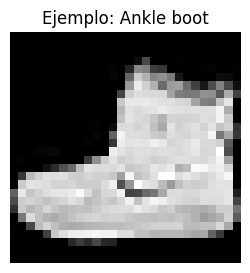


Definiendo modelo funcional...

Entrenando modelo funcional...
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 2.0879 - output_par_impar_prenda_accuracy: 0.8251 - output_par_impar_prenda_loss: 0.4331 - output_prenda_accuracy: 0.4550 - output_prenda_loss: 1.6548 - val_loss: 1.1088 - val_output_par_impar_prenda_accuracy: 0.9445 - val_output_par_impar_prenda_loss: 0.1941 - val_output_prenda_accuracy: 0.7033 - val_output_prenda_loss: 0.9147
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 1.0127 - output_par_impar_prenda_accuracy: 0.9502 - output_par_impar_prenda_loss: 0.1815 - output_prenda_accuracy: 0.7389 - output_prenda_loss: 0.8312 - val_loss: 0.9312 - val_output_par_impar_prenda_accuracy: 0.9496 - val_output_par_impar_prenda_loss: 0.1568 - val_output_prenda_accuracy: 0.7308 - val_output_prenda_loss: 0.7744
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.8617 - output_par_impar_prenda_accuracy: 0.9513 - output_par_impar_prenda_loss: 0.1512 - o

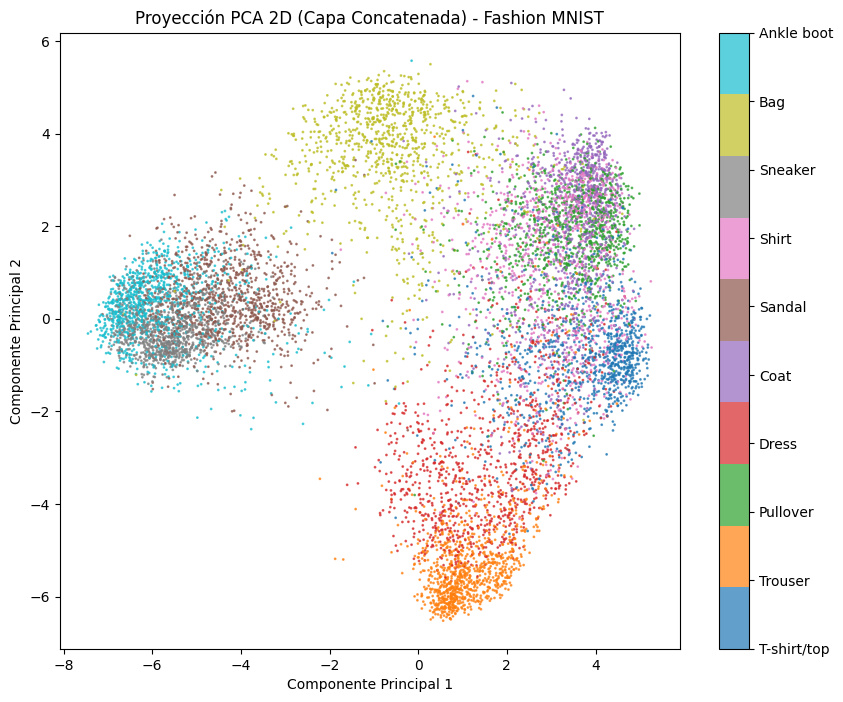


--- Aplicando UMAP (RAPIDS) ---
[2025-11-10 02:31:49.189] [CUML] [info] build_algo set to brute_force_knn because random_state is given


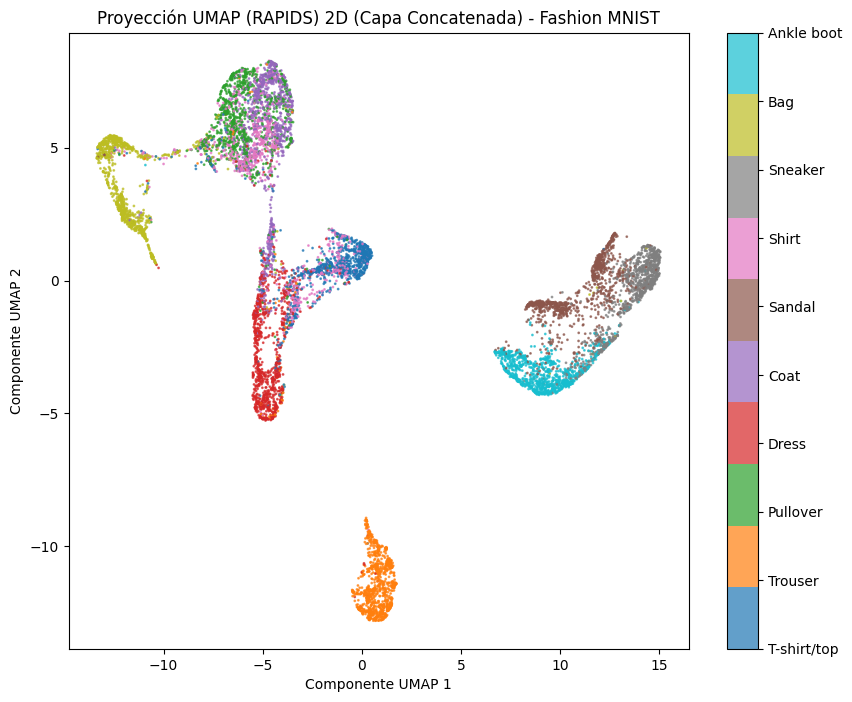

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import pandas as pd

# Importar cuml (RAPIDS)
try:
    import cuml
    print("RAPIDS (cuml) importado correctamente.")
except ImportError:
    print("ERROR: No se pudo importar 'cuml'.")
    print("Asegúrate de haber instalado RAPIDS y reiniciado el entorno.")

# --- 1. Cargar Datos (Fashion MNIST) ---
print("\nCargando y preparando datos (Fashion MNIST)...")
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Definir los nombres de las clases
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Aplicar la partición 5k/55k
X_train, X_valid = X_train_full[:-55000], X_train_full[-55000:]
y_train, y_valid = y_train_full[:-55000], y_train_full[-55000:]

# Añadir canal de color (newaxis) y normalizar
X_train = X_train[..., np.newaxis]/255.
X_valid = X_valid[..., np.newaxis]/255.
X_test = X_test[..., np.newaxis]/255.

print(f"Shapes: Train={X_train.shape}, Valid={X_valid.shape}, Test={X_test.shape}")

# --- 2. Crear Entradas (SIN RUIDO) ---
print("Creando 3 entradas idénticas (sin ruido)...")
# Alimentamos las 3 entradas del modelo con la misma imagen limpia
inputs_train = [X_train, X_train, X_train]
inputs_valid = [X_valid, X_valid, X_valid]
inputs_test = [X_test, X_test, X_test]

# Visualizar una imagen de ejemplo
plt.figure(figsize=(3, 3))
plt.imshow(X_train[0, :, :, 0], cmap='gray')
plt.title(f"Ejemplo: {class_names[y_train[0]]}")
plt.axis('off')
plt.show()


# --- 3. Definir y Entrenar Modelo Funcional (3 Entradas, 2 Salidas) ---
print("\nDefiniendo modelo funcional...")
tf.keras.backend.clear_session()

# Entradas
input_1 = tf.keras.layers.Input(shape=[28,28,1], name="input_1_limpia")
input_2 = tf.keras.layers.Input(shape=[28,28,1], name="input_2_limpia")
input_3 = tf.keras.layers.Input(shape=[28,28,1], name="input_3_limpia")

# Aplanar entradas
flatten_1 = tf.keras.layers.Flatten()(input_1)
flatten_2 = tf.keras.layers.Flatten()(input_2)
flatten_3 = tf.keras.layers.Flatten()(input_3)

# Ramas de la red (MLP)
h1_1 = tf.keras.layers.Dense(200,activation='tanh',name='h1_1')(flatten_1)
h2_1 = tf.keras.layers.Dense(50,activation='tanh',name='h2_1')(h1_1)

h1_2 = tf.keras.layers.Dense(200,activation='tanh',name='h1_2')(flatten_2)
h2_2 = tf.keras.layers.Dense(50,activation='tanh',name='h2_2')(h1_2)

h1_3 = tf.keras.layers.Dense(200,activation='tanh',name='h1_3')(flatten_3)
h2_3 = tf.keras.layers.Dense(50,activation='tanh',name='h2_3')(h1_3)

# Capa de concatenación (esta es la que vamos a visualizar)
concat = tf.keras.layers.concatenate([h2_1, h2_2, h2_3], name="concatenate_features")

# Salidas (2 salidas: prenda y par/impar sobre el ID de la prenda)
output_class = tf.keras.layers.Dense(10, activation="softmax", name='output_prenda')(concat)
output_even_odd = tf.keras.layers.Dense(1, activation="sigmoid", name='output_par_impar_prenda')(concat)

# Crear el modelo
model_fun = tf.keras.Model(inputs=[input_1, input_2, input_3], outputs=[output_class, output_even_odd])

# Preparar etiquetas para las 2 salidas
# Salida 1: Prenda (0-9)
y_train_d, y_valid_d, y_test_d = y_train, y_valid, y_test
# Salida 2: Par/Impar (sobre el ID de la prenda 0-9)
y_train_p = (y_train % 2 != 0).astype(int)
y_valid_p = (y_valid % 2 != 0).astype(int)
y_test_p = (y_test % 2 != 0).astype(int)

# Compilar el modelo
model_fun.compile(loss={"output_prenda": "sparse_categorical_crossentropy", "output_par_impar_prenda": "binary_crossentropy"},
                  optimizer="sgd",
                  metrics={"output_prenda": "accuracy", "output_par_impar_prenda": "accuracy"})

# Entrenar el modelo
print("\nEntrenando modelo funcional...")
history = model_fun.fit(
    inputs_train, [y_train_d, y_train_p],
    epochs=10, # 10 épocas para un entrenamiento rápido
    validation_data=(inputs_valid, [y_valid_d, y_valid_p]),
    verbose=1
)

# --- 4. Extraer Atributos y Aplicar PCA ---
print("\n--- Extrayendo atributos y aplicando PCA ---")

# Crear un modelo extractor
extractor = tf.keras.Model(inputs=model_fun.inputs,
                           outputs=model_fun.get_layer("concatenate_features").output)

# Predecir para obtener los atributos (usamos el conjunto de test)
features = extractor.predict(inputs_test)
labels = y_test
print(f"Shape de atributos extraídos: {features.shape}")

# Aplicar PCA para reducir a 2D
pca = PCA(n_components=2, random_state=42)
features_pca = pca.fit_transform(features)

# Graficar PCA
plt.figure(figsize=(10, 8))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap="tab10", s=1, alpha=0.7)
plt.title("Proyección PCA 2D (Capa Concatenada) - Fashion MNIST")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
# Añadir leyenda de clases
cbar = plt.colorbar()
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(class_names)
plt.show()

# --- 5. Aplicar UMAP - RAPIDS ---
print("\n--- Aplicando UMAP (RAPIDS) ---")

# Asegurarse de que los datos estén en float32 para cuml
features_cuml = features.astype(np.float32)

# Aplicar UMAP
umap_model = cuml.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
features_umap = umap_model.fit_transform(features_cuml)

# Graficar UMAP
plt.figure(figsize=(10, 8))
plt.scatter(features_umap[:, 0], features_umap[:, 1], c=labels, cmap="tab10", s=1, alpha=0.7)
plt.title("Proyección UMAP (RAPIDS) 2D (Capa Concatenada) - Fashion MNIST")
plt.xlabel("Componente UMAP 1")
plt.ylabel("Componente UMAP 2")
# Añadir leyenda de clases
cbar = plt.colorbar()
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(class_names)
plt.show()

##Números

Cargando y preparando datos (MNIST-dígitos)...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Shapes: Train=(5000, 28, 28, 1), Valid=(55000, 28, 28, 1), Test=(10000, 28, 28, 1)
Generando entradas con ruido...
Mostrando ejemplo de entradas:


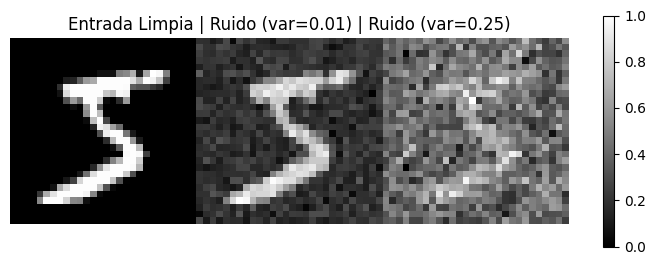


Definiendo modelo funcional original...

Entrenando modelo funcional...
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 2.4719 - output_digit_accuracy: 0.4125 - output_digit_loss: 1.9185 - output_even_odd_accuracy: 0.7488 - output_even_odd_loss: 0.5534 - val_loss: 1.6029 - val_output_digit_accuracy: 0.7075 - val_output_digit_loss: 1.1892 - val_output_even_odd_accuracy: 0.8165 - val_output_even_odd_loss: 0.4136
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 1.4141 - output_digit_accuracy: 0.7551 - output_digit_loss: 1.0408 - output_even_odd_accuracy: 0.8497 - output_even_odd_loss: 0.3732 - val_loss: 1.1742 - val_output_digit_accuracy: 0.8119 - val_output_digit_loss: 0.8229 - val_output_even_odd_accuracy: 0.8491 - val_output_even_odd_loss: 0.3513
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 1.0493 - output_digit_accuracy: 0.8347 - output_digit_loss: 0.7282 - output_even_odd_accuracy: 0.8668 - output_even_odd_loss: 0.3211 - val_loss: 1.0013 - v

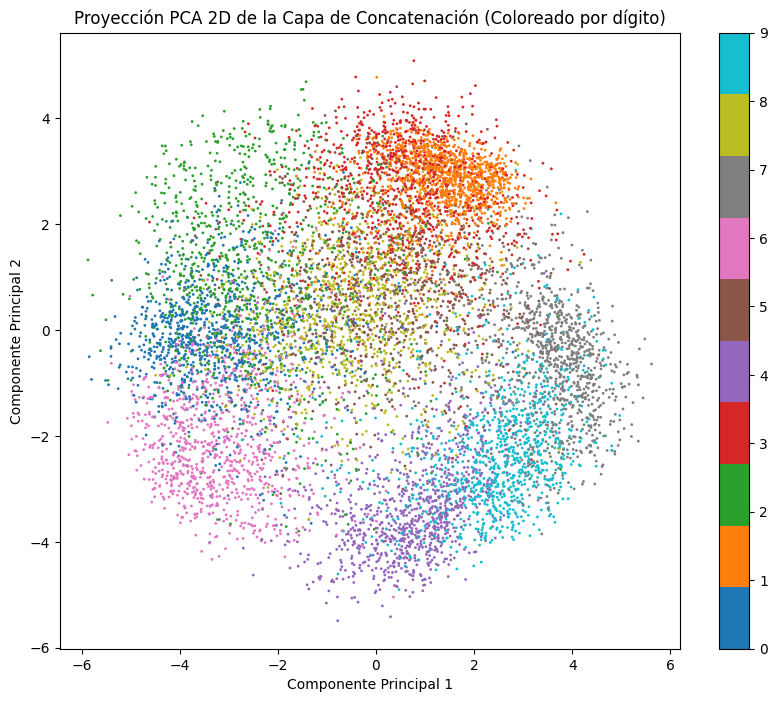


--- Ejercicio 2: Aplicando UMAP (RAPIDS) ---
[2025-11-10 02:39:39.692] [CUML] [info] build_algo set to brute_force_knn because random_state is given


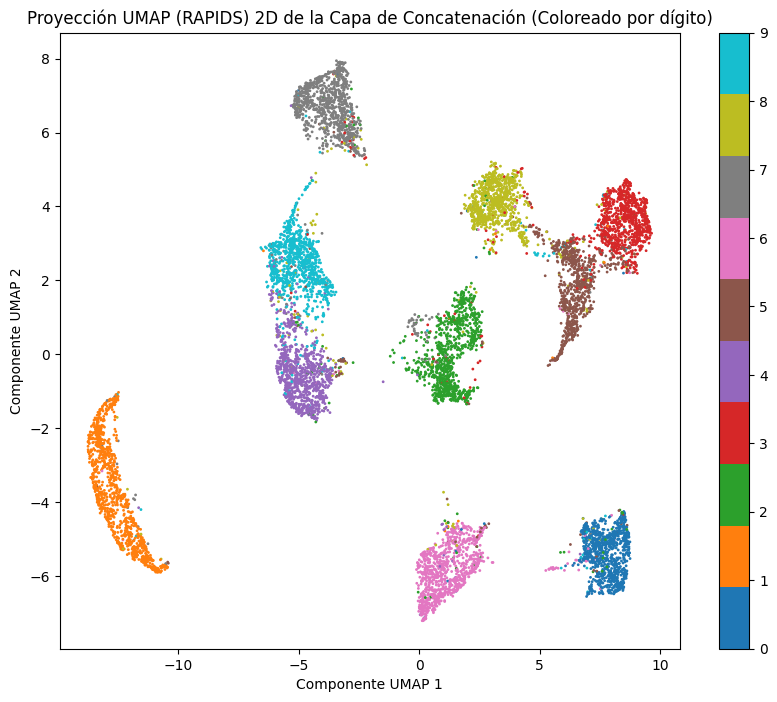

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import cuml # (De RAPIDS, se importará después del reinicio)
import pandas as pd

# --- 1. Cargar Datos (Ayuda 1) ---
print("Cargando y preparando datos (MNIST-dígitos)...")
# (X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Aplicar la partición 5k/55k
X_train, X_valid = X_train_full[:-55000], X_train_full[-55000:]
y_train, y_valid = y_train_full[:-55000], y_train_full[-55000:]

# Añadir canal de color (newaxis) y normalizar
X_train = X_train[..., np.newaxis]/255.
X_valid = X_valid[..., np.newaxis]/255.
X_test = X_test[..., np.newaxis]/255.

print(f"Shapes: Train={X_train.shape}, Valid={X_valid.shape}, Test={X_test.shape}")

# --- 2. Crear Entradas con Ruido (Ayuda 2) ---
print("Generando entradas con ruido...")
var_ = [0.01, 0.25]
inputs_train = [X_train]
inputs_valid = [X_valid]
inputs_test = [X_test]

# Recorrer varianzas para generar datos con ruido
for var_i in var_:
    # Ruido para Train
    dim = X_train.shape
    tmp = X_train + (np.sqrt(var_i)*np.random.randn(X_train.shape[0],dim[1],dim[2],dim[3]))
    tmp = MinMaxScaler().fit_transform(tmp.reshape(dim[0],-1).T).T #fijar señal con ruido de 0 a 1
    inputs_train += [tmp.reshape(dim)]

    # Ruido para Valid
    dim = X_valid.shape
    tmp = X_valid + (np.sqrt(var_i)*np.random.randn(X_valid.shape[0],dim[1],dim[2],dim[3]))
    tmp = MinMaxScaler().fit_transform(tmp.reshape(dim[0],-1).T).T
    inputs_valid += [tmp.reshape(dim)]

    # Ruido para Test
    dim = X_test.shape
    tmp = X_test + (np.sqrt(var_i)*np.random.randn(X_test.shape[0],dim[1],dim[2],dim[3]))
    tmp = MinMaxScaler().fit_transform(tmp.reshape(dim[0],-1).T).T
    inputs_test += [tmp.reshape(dim)]

# Visualizar las imágenes (limpia, ruido 1, ruido 2)
print("Mostrando ejemplo de entradas:")
plt.figure(figsize=(9, 3))
plt.imshow(np.c_[inputs_train[0][0,:,:,0], inputs_train[1][0,:,:,0], inputs_train[2][0,:,:,0]], cmap='gray')
plt.title("Entrada Limpia | Ruido (var=0.01) | Ruido (var=0.25)")
plt.axis('off')
plt.colorbar()
plt.show()


# --- 3. Definir y Entrenar Modelo Funcional (de 2_DL_Keras_API_funcional.ipynb) ---
print("\nDefiniendo modelo funcional original...")
tf.keras.backend.clear_session()

# Entradas
input_1 = tf.keras.layers.Input(shape=[28,28,1], name="input_1_limpia")
input_2 = tf.keras.layers.Input(shape=[28,28,1], name="input_2_ruido01")
input_3 = tf.keras.layers.Input(shape=[28,28,1], name="input_3_ruido25")

# Aplanar entradas
flatten_1 = tf.keras.layers.Flatten()(input_1)
flatten_2 = tf.keras.layers.Flatten()(input_2)
flatten_3 = tf.keras.layers.Flatten()(input_3)

# Ramas de la red (MLP)
h1_1 = tf.keras.layers.Dense(200,activation='tanh',name='h1_1')(flatten_1)
h2_1 = tf.keras.layers.Dense(50,activation='tanh',name='h2_1')(h1_1)

h1_2 = tf.keras.layers.Dense(200,activation='tanh',name='h1_2')(flatten_2)
h2_2 = tf.keras.layers.Dense(50,activation='tanh',name='h2_2')(h1_2)

h1_3 = tf.keras.layers.Dense(200,activation='tanh',name='h1_3')(flatten_3)
h2_3 = tf.keras.layers.Dense(50,activation='tanh',name='h2_3')(h1_3)

# Capa de concatenación (esta es la que vamos a visualizar)
concat = tf.keras.layers.concatenate([h2_1, h2_2, h2_3], name="concatenate_features")

# Salidas (2 salidas: dígito y par/impar)
output_digit = tf.keras.layers.Dense(10, activation="softmax", name='output_digit')(concat)
output_even_odd = tf.keras.layers.Dense(1, activation="sigmoid", name='output_even_odd')(concat)

# Crear el modelo
model_fun = tf.keras.Model(inputs=[input_1, input_2, input_3], outputs=[output_digit, output_even_odd])

# Preparar etiquetas para las 2 salidas
# Salida 1: Dígito
y_train_d, y_valid_d, y_test_d = y_train, y_valid, y_test
# Salida 2: Par/Impar (0 si es par, 1 si es impar)
y_train_p = (y_train % 2 != 0).astype(int)
y_valid_p = (y_valid % 2 != 0).astype(int)
y_test_p = (y_test % 2 != 0).astype(int)

# Compilar el modelo
model_fun.compile(loss={"output_digit": "sparse_categorical_crossentropy", "output_even_odd": "binary_crossentropy"},
                  optimizer="sgd",
                  metrics={"output_digit": "accuracy", "output_even_odd": "accuracy"})

# Entrenar el modelo
print("\nEntrenando modelo funcional...")
history = model_fun.fit(
    inputs_train, [y_train_d, y_train_p],
    epochs=10, # 10 épocas para un entrenamiento rápido
    validation_data=(inputs_valid, [y_valid_d, y_valid_p]),
    verbose=1
)

# --- 4. Extraer Atributos y Aplicar PCA (Ejercicio 1) ---
print("\n--- Ejercicio 1: Extrayendo atributos y aplicando PCA ---")

# Crear un modelo extractor
extractor = tf.keras.Model(inputs=model_fun.inputs,
                           outputs=model_fun.get_layer("concatenate_features").output)

# Predecir para obtener los atributos (usamos el conjunto de test)
features = extractor.predict(inputs_test)
labels = y_test
print(f"Shape de atributos extraídos: {features.shape}")

# Aplicar PCA para reducir a 2D
pca = PCA(n_components=2, random_state=42)
features_pca = pca.fit_transform(features)

# Graficar PCA
plt.figure(figsize=(10, 8))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap="tab10", s=1)
plt.title("Proyección PCA 2D de la Capa de Concatenación (Coloreado por dígito)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar()
plt.show()

# --- 5. Aplicar UMAP - RAPIDS (Ejercicio 2) ---
print("\n--- Ejercicio 2: Aplicando UMAP (RAPIDS) ---")

# Asegurarse de que los datos estén en float32 para cuml
features = features.astype(np.float32)

# Aplicar UMAP
umap_model = cuml.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
features_umap = umap_model.fit_transform(features)

# Graficar UMAP
plt.figure(figsize=(10, 8))
plt.scatter(features_umap[:, 0], features_umap[:, 1], c=labels, cmap="tab10", s=1)
plt.title("Proyección UMAP (RAPIDS) 2D de la Capa de Concatenación (Coloreado por dígito)")
plt.xlabel("Componente UMAP 1")
plt.ylabel("Componente UMAP 2")
plt.colorbar()
plt.show()

In [5]:
# --- Preparar las etiquetas de salida (Targets) ---

# 1. Salida de Dígitos (ya la tenemos)
y_train_d, y_valid_d, y_test_d = y_train, y_valid, y_test

# 2. Salida Par/Impar (basado en tu ayuda de código)
# (0 = Par, 1 = Impar)
y_train_p = (y_train % 2).astype(int)
y_valid_p = (y_valid % 2).astype(int)
y_test_p = (y_test % 2).astype(int)

# Verificar (usando tu ejemplo)
print("--- Verificación de etiquetas Par/Impar ---")
print("Dígitos:", y_train[10:15])
print("Par/Impar:", y_train_p[10:15])

--- Verificación de etiquetas Par/Impar ---
Dígitos: [3 5 3 6 1]
Par/Impar: [1 1 1 0 1]


Model: "cnn_3_entradas_2_salidas"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_limpia        │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ruido_1       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ruido_2       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_body_compartido │ (None, 3136)      │     18,816 │ input_limpia[0][… │
│ (Functional)        │                   │            │ input_ruido_1[0]… │
│                     │                   │            │ input_ruido_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 9408)      │          0 │ cnn_body_compart… │
│ (Concatenate)       │                   │            │ cnn_body_compart… │
│                     │                   │            │ cnn_body_compart… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  1,204,352 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_digit        │ (None, 10)        │      1,290 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_par_impar    │ (None, 1)         │        129 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,224,587 (4.67 MB)

 Trainable params: 1,224,587 (4.67 MB)

 Non-trainable params: 0 (0.00 B)

None


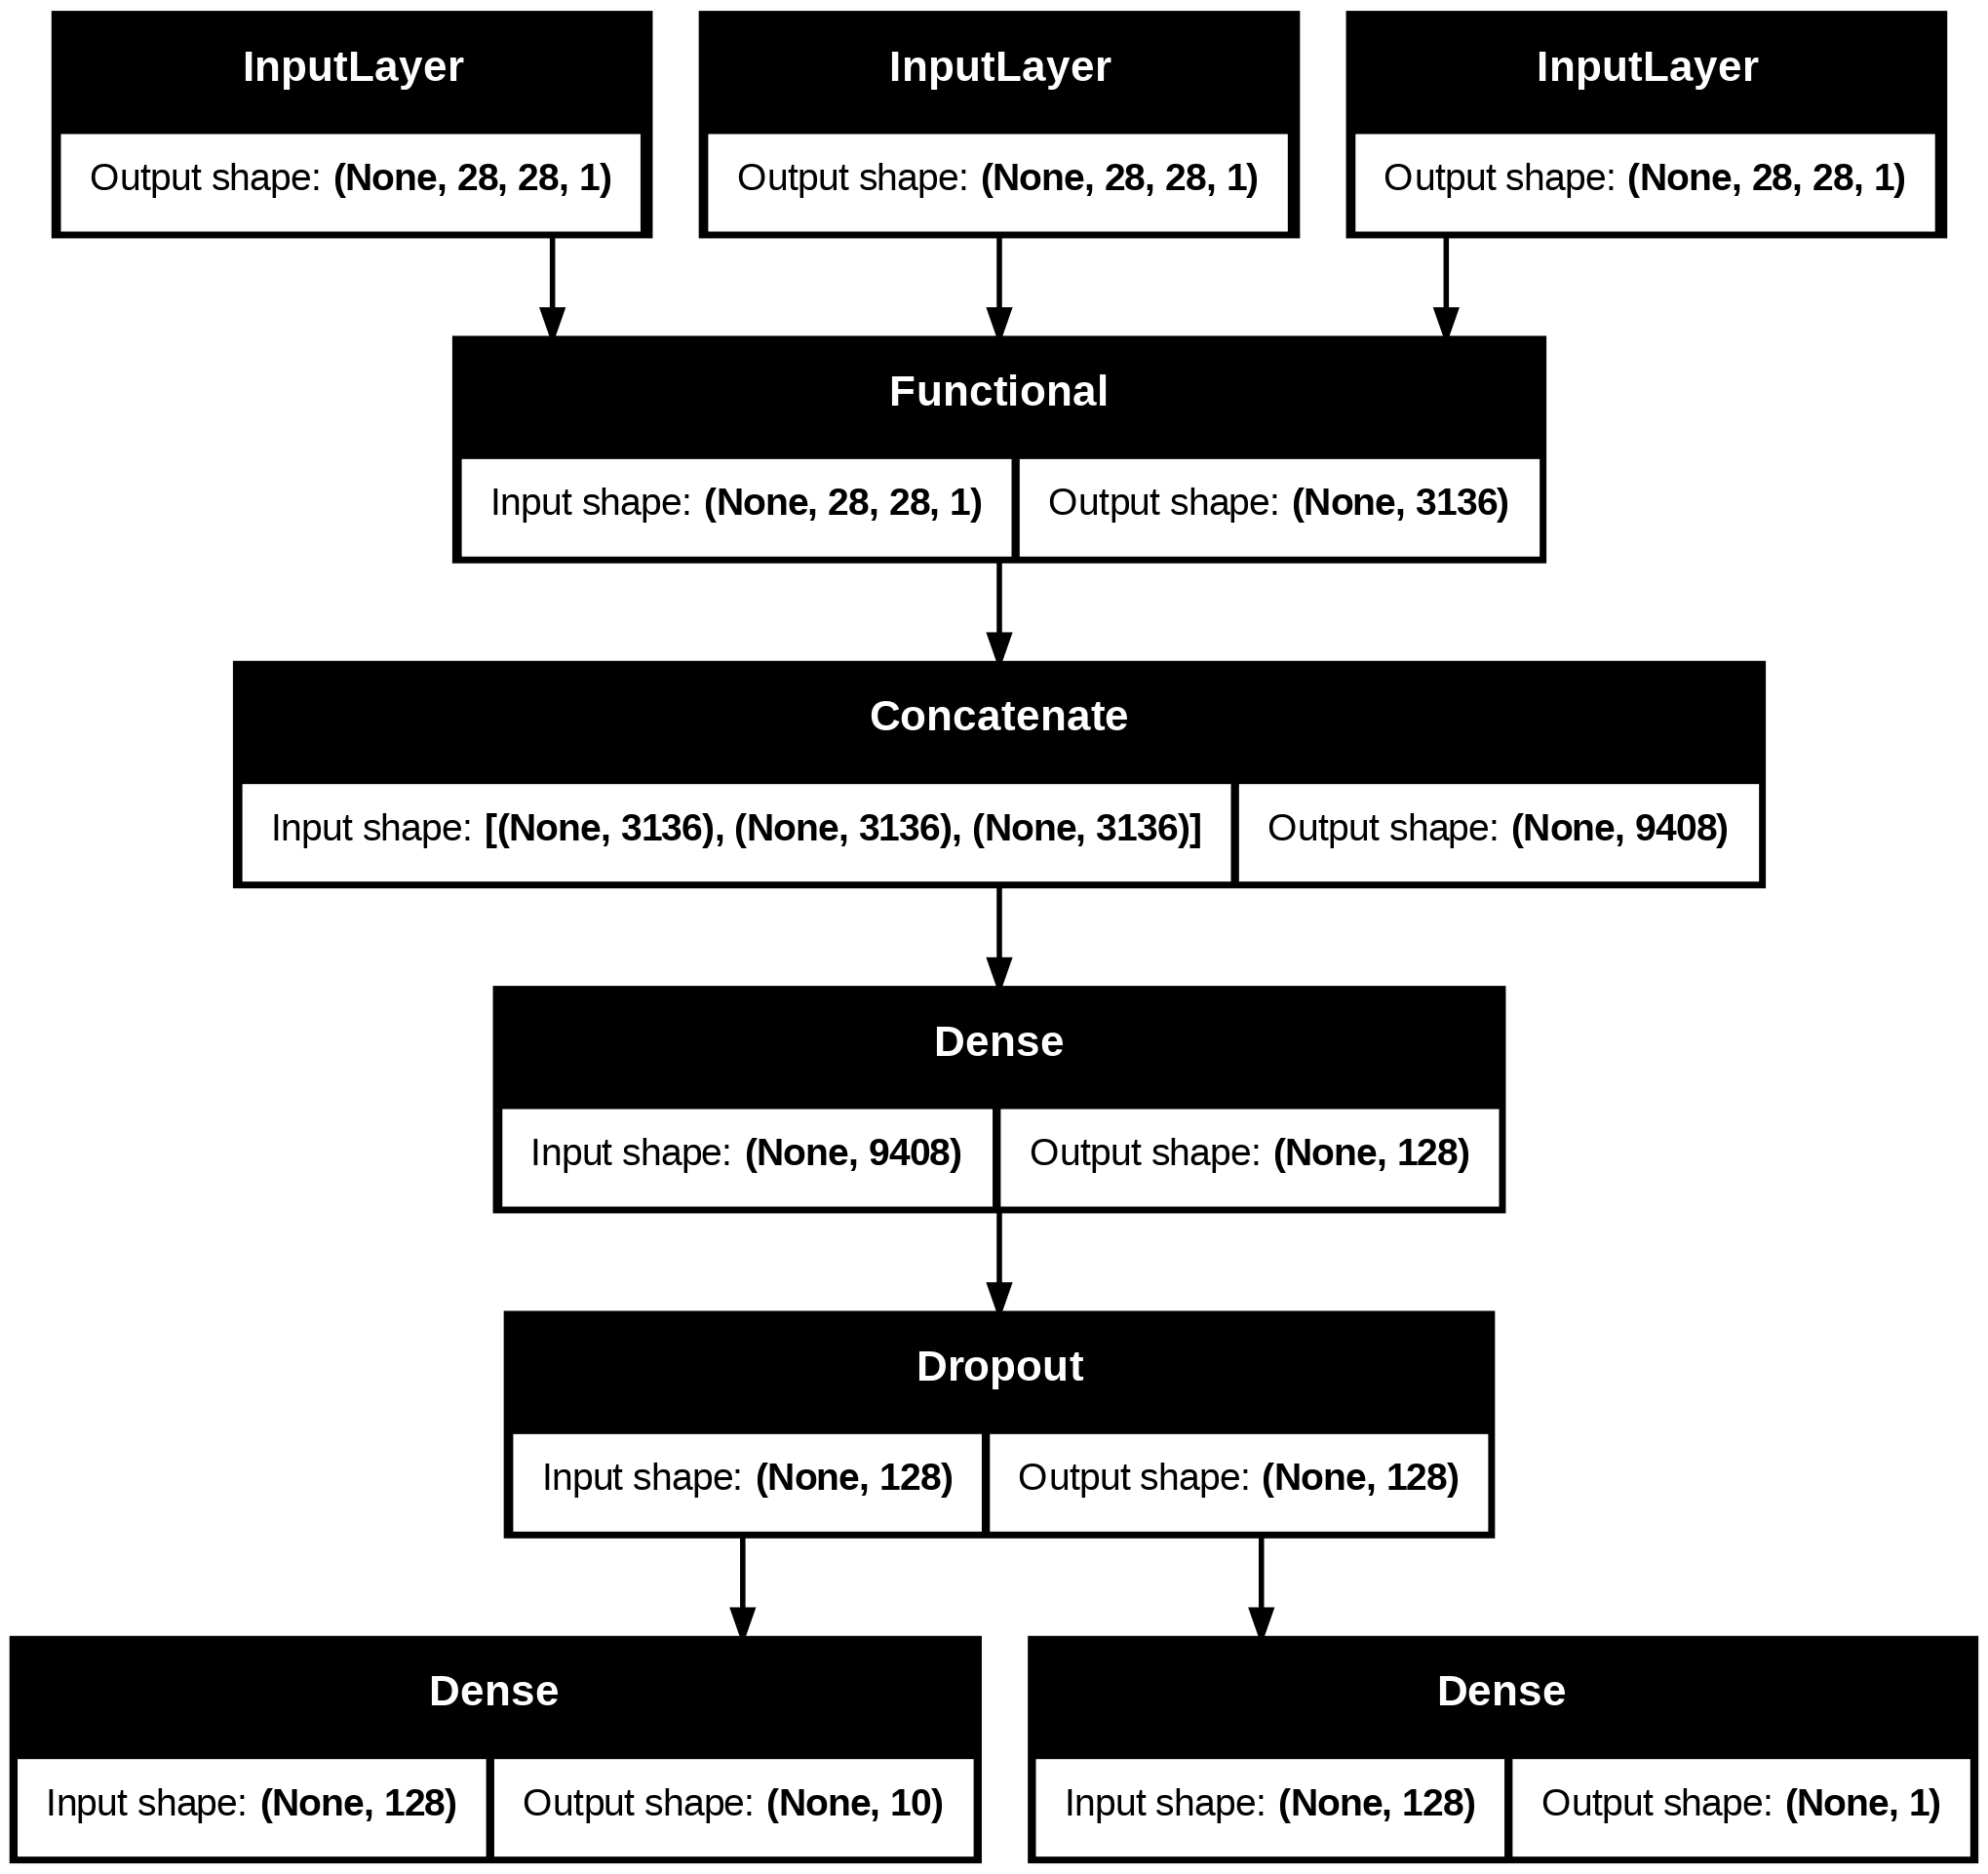

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Limpiar la sesión de Keras
tf.keras.backend.clear_session()

# --- 1. Definir las 3 Entradas ---
# (Asumimos la forma [28, 28, 1] que creamos en el paso anterior)
input_clean = tf.keras.layers.Input(shape=[28, 28, 1], name="input_limpia")
input_noisy1 = tf.keras.layers.Input(shape=[28, 28, 1], name="input_ruido_1")
input_noisy2 = tf.keras.layers.Input(shape=[28, 28, 1], name="input_ruido_2")

# --- 2. Definir el Cuerpo CNN Compartido (Shared Body) ---
# Basado en la arquitectura de 3_Introduccion_CNN.ipynb
# Creamos un "sub-modelo" que procesará cada entrada.
cnn_input = tf.keras.layers.Input(shape=[28, 28, 1])
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(cnn_input)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Flatten()(x)
# Este es el modelo del cuerpo CNN
cnn_body = tf.keras.Model(inputs=cnn_input, outputs=x, name="cnn_body_compartido")

# --- 3. Aplicar el Cuerpo Compartido a las 3 Entradas ---
# Los pesos de 'cnn_body' se reutilizan para las tres entradas
features_clean = cnn_body(input_clean)
features_noisy1 = cnn_body(input_noisy1)
features_noisy2 = cnn_body(input_noisy2)

# --- 4. Concatenar Atributos y Cabezas de Salida ---
# Unimos los 3 vectores de características
concatenated_features = tf.keras.layers.concatenate([features_clean, features_noisy1, features_noisy2])

# Agregamos una capa densa para mezclar las características
mixed = tf.keras.layers.Dense(128, activation='relu')(concatenated_features)
mixed = tf.keras.layers.Dropout(0.3)(mixed) # Dropout para regularización

# --- 5. Definir las 2 Salidas ---
# Salida 1: Estimación del dígito (10 clases)
output_digit = tf.keras.layers.Dense(10, activation='softmax', name='output_digit')(mixed)

# Salida 2: Estimación par/impar (1 clase, binaria)
output_even_odd = tf.keras.layers.Dense(1, activation='sigmoid', name='output_par_impar')(mixed)

# --- 6. Construir el Modelo Final ---
new_model_cnn = tf.keras.Model(
    inputs=[input_clean, input_noisy1, input_noisy2],
    outputs=[output_digit, output_even_odd],
    name="cnn_3_entradas_2_salidas"
)

# Mostrar el resumen de la arquitectura
print(new_model_cnn.summary())

# Generar un gráfico del modelo
tf.keras.utils.plot_model(new_model_cnn, show_shapes=True, to_file="new_cnn_model.png")

In [7]:
# --- 1. Compilar el Modelo ---
# Usamos dos funciones de pérdida diferentes
new_model_cnn.compile(
    loss={
        "output_digit": "sparse_categorical_crossentropy",
        "output_par_impar": "binary_crossentropy"
    },
    # Opcional: Ponderar las pérdidas (dar más importancia al dígito)
    loss_weights={"output_digit": 0.8, "output_par_impar": 0.2},

    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),

    metrics={
        "output_digit": "accuracy",
        "output_par_impar": "accuracy"
    }
)

# --- 2. Entrenar el Modelo ---
print("\n--- Iniciando Entrenamiento del Modelo CNN ---")

# Pasamos las listas de entradas (inputs_train) y
# las listas de salidas ([y_train_d, y_train_p])
history_cnn = new_model_cnn.fit(
    inputs_train, [y_train_d, y_train_p],
    epochs=15, # 15 épocas para un buen entrenamiento
    batch_size=64,
    validation_data=(inputs_valid, [y_valid_d, y_valid_p]),
    verbose=1
)

# --- 3. Evaluar el Modelo ---
print("\n--- Evaluación en el Conjunto de Prueba ---")
results = new_model_cnn.evaluate(inputs_test, [y_test_d, y_test_p], batch_size=64)

print("\nResultados de Evaluación (Test):")
for name, value in zip(new_model_cnn.metrics_names, results):
    print(f"{name}: {value:.4f}")


--- Iniciando Entrenamiento del Modelo CNN ---
Epoch 1/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - loss: 1.2812 - output_digit_accuracy: 0.5099 - output_digit_loss: 1.4536 - output_par_impar_accuracy: 0.6574 - output_par_impar_loss: 0.5916 - val_loss: 0.2533 - val_output_digit_accuracy: 0.9223 - val_output_digit_loss: 0.2532 - val_output_par_impar_accuracy: 0.9078 - val_output_par_impar_loss: 0.2530
Epoch 2/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.2578 - output_digit_accuracy: 0.9195 - output_digit_loss: 0.2599 - output_par_impar_accuracy: 0.8954 - output_par_impar_loss: 0.2493 - val_loss: 0.1706 - val_output_digit_accuracy: 0.9439 - val_output_digit_loss: 0.1784 - val_output_par_impar_accuracy: 0.9505 - val_output_par_impar_loss: 0.1391
Epoch 3/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.1629 - output_digit_accuracy: 0.9485 - output_digit_loss: 0.1676 - output_par_impar_accuracy: 0.9488 - output_par_impar_loss: 0.1447 - val_loss: 0.1270 - val_output_digit_accu

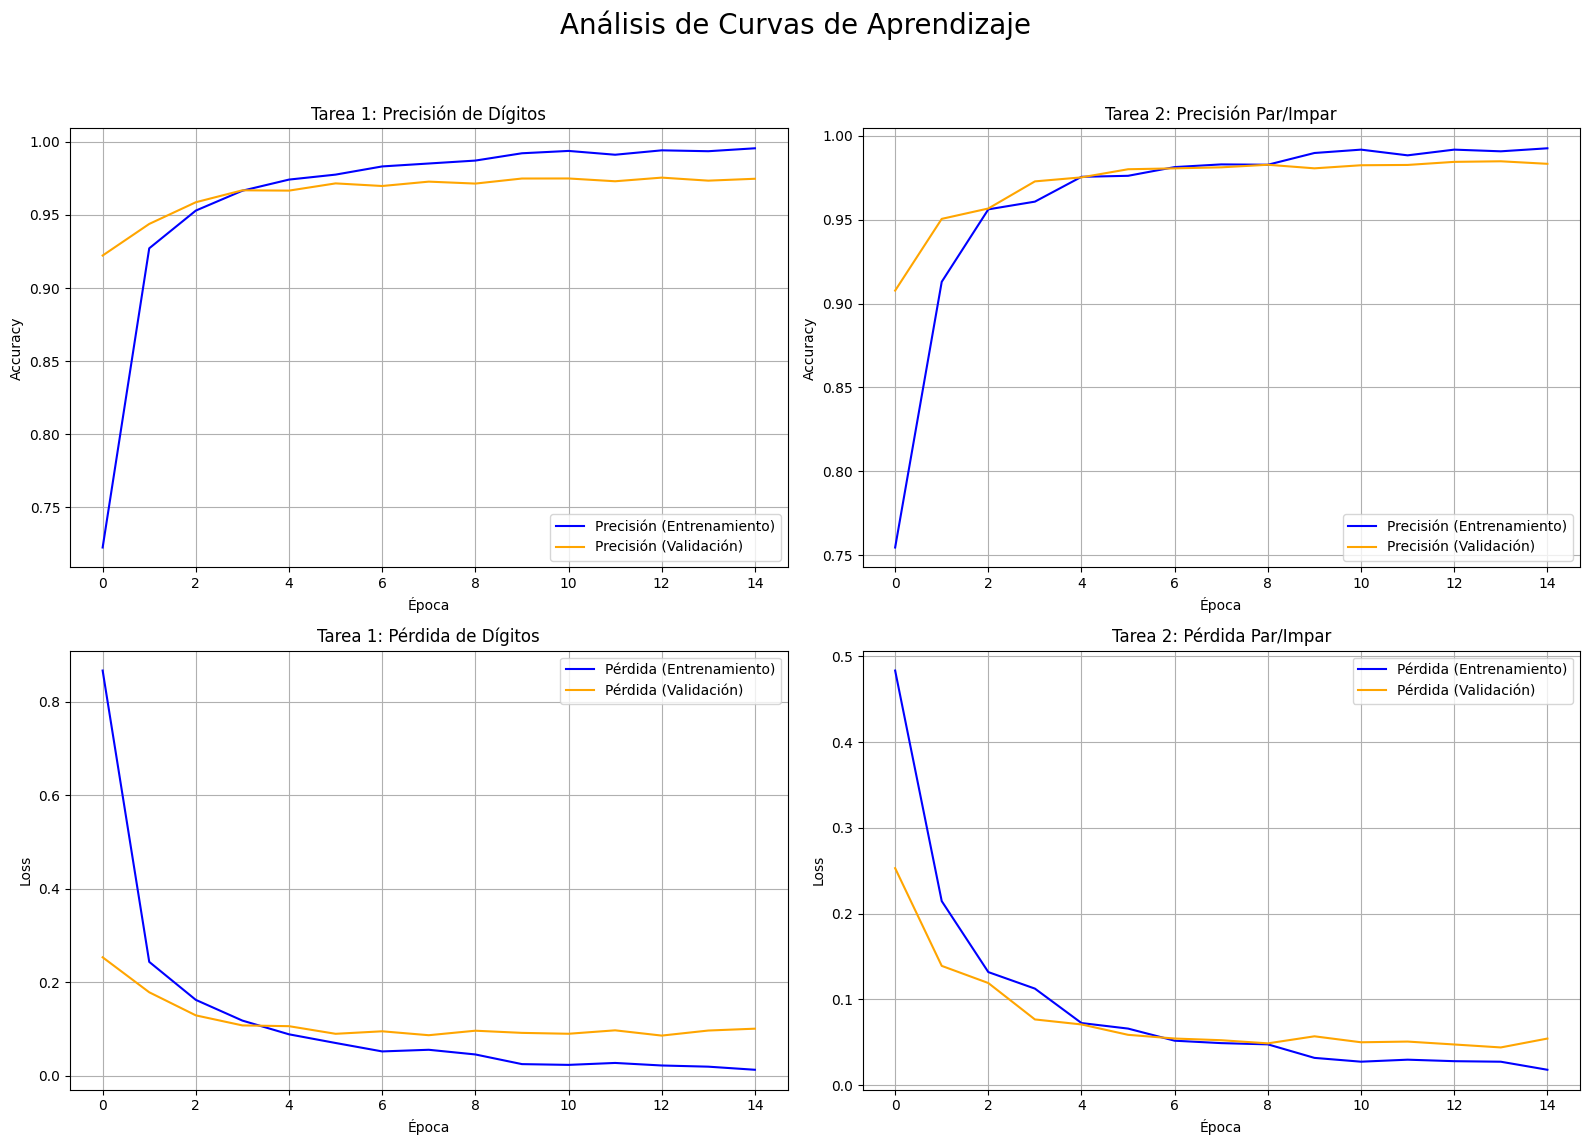

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir el historial a un DataFrame de Pandas para fácil manejo
history_df = pd.DataFrame(history_cnn.history)

# --- Crear una cuadrícula de 2x2 para las gráficas ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis de Curvas de Aprendizaje', fontsize=20)

# --- Gráfica 1: Precisión (Accuracy) de DÍGITOS ---
axes[0, 0].plot(history_df['output_digit_accuracy'], label='Precisión (Entrenamiento)', color='blue')
axes[0, 0].plot(history_df['val_output_digit_accuracy'], label='Precisión (Validación)', color='orange')
axes[0, 0].set_title('Tarea 1: Precisión de Dígitos')
axes[0, 0].set_xlabel('Época')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# --- Gráfica 2: Precisión (Accuracy) de PAR/IMPAR ---
axes[0, 1].plot(history_df['output_par_impar_accuracy'], label='Precisión (Entrenamiento)', color='blue')
axes[0, 1].plot(history_df['val_output_par_impar_accuracy'], label='Precisión (Validación)', color='orange')
axes[0, 1].set_title('Tarea 2: Precisión Par/Impar')
axes[0, 1].set_xlabel('Época')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# --- Gráfica 3: Pérdida (Loss) de DÍGITOS ---
axes[1, 0].plot(history_df['output_digit_loss'], label='Pérdida (Entrenamiento)', color='blue')
axes[1, 0].plot(history_df['val_output_digit_loss'], label='Pérdida (Validación)', color='orange')
axes[1, 0].set_title('Tarea 1: Pérdida de Dígitos')
axes[1, 0].set_xlabel('Época')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# --- Gráfica 4: Pérdida (Loss) de PAR/IMPAR ---
axes[1, 1].plot(history_df['output_par_impar_loss'], label='Pérdida (Entrenamiento)', color='blue')
axes[1, 1].plot(history_df['val_output_par_impar_loss'], label='Pérdida (Validación)', color='orange')
axes[1, 1].set_title('Tarea 2: Pérdida Par/Impar')
axes[1, 1].set_xlabel('Época')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


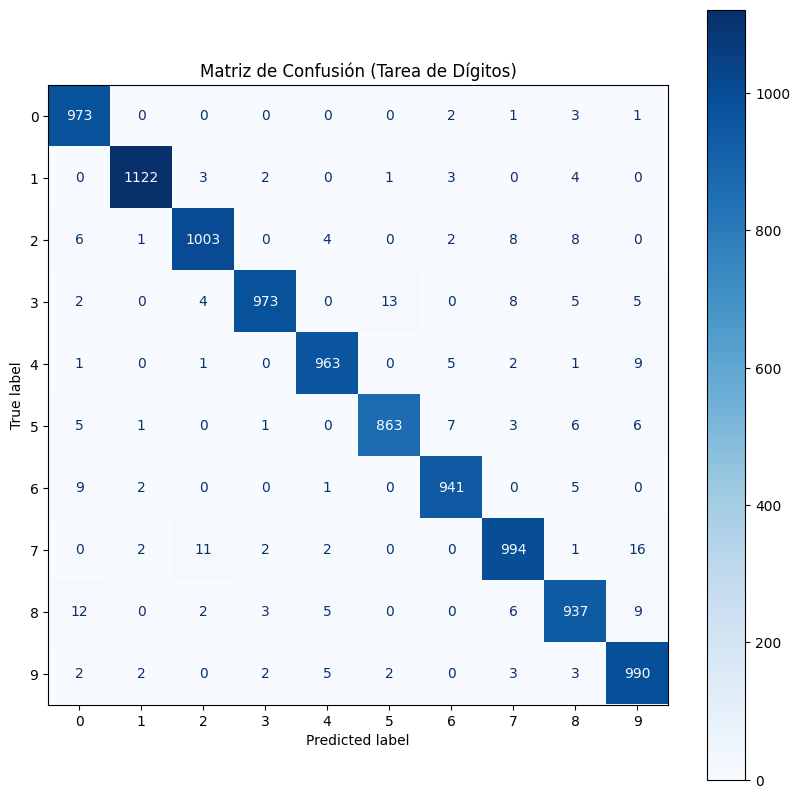

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# --- 1. Obtener predicciones del conjunto de TEST ---
# El modelo devuelve una lista: [pred_digitos, pred_par_impar]
y_pred_list = new_model_cnn.predict(inputs_test)

# --- 2. Extraer las predicciones de DÍGITOS ---
# (Las predicciones son probabilidades, necesitamos la clase con max prob)
y_pred_digit_probs = y_pred_list[0]
y_pred_digit_labels = np.argmax(y_pred_digit_probs, axis=1)

# --- 3. Calcular la Matriz de Confusión ---
# Comparamos las etiquetas reales (y_test_d) con las predichas (y_pred_digit_labels)
cm = confusion_matrix(y_test_d, y_pred_digit_labels)

# --- 4. Graficar la Matriz ---
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='horizontal')
plt.title('Matriz de Confusión (Tarea de Dígitos)')
plt.show()